In [0]:
!pip install -U -q PyDrive
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
# Load Libs for Google Collab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
##########
%matplotlib inline

In [0]:
file_id = '11JrgqGJ3fZBjPxnOln3XP-_Zyy9_Oltd'

def setMode(mode):
    if (mode == 1): 
        googleColab()
    if (mode == 2):
        rootdir = 'ANACONDA_DIRECTORY'
        df = pd.read_csv(rootdir+'DATASET.csv',sep='\t', decimal=',', encoding='utf-8')

def googleColab():
    global URI 
    URI = 'COLAB_DIRECTORY'
    # Authenticate
    auth.authenticate_user()
    global gauth
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    global drive 
    drive = GoogleDrive(gauth)
    from googleapiclient.discovery import build
    global drive_service 
    drive_service = build('drive', 'v3')
    
    listed = drive.ListFile({'q': "title contains 'dataset_resampled.csv' and 'root' in parents"}).GetList()
    for file in listed:
      print('title {}, id {}'.format(file['title'], file['id']))
      
    dataset_downloaded = drive.CreateFile({'id': file_id,
                                           'title': 'dataset_resampled.csv',
                                          'parents': 'XXX'})
    dataset_downloaded.GetContentFile('dataset_resampled.csv')
    

https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64

In [0]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

setMode(1)
df = pd.read_csv('dataset_resampled.csv', sep='\t', decimal=',', encoding='utf-8')
        
print(df.loc[1])

timestamp    2018-08-04 07:41:03.150
acc_x                     0.00339452
acc_y                      0.0666913
acc_z                        0.19066
acc_m                       0.202016
gyr_x                     0.00210571
gyr_y                       0.015152
gyr_z                       0.011734
gyr_m                      0.0192796
mag_x                       -17.5232
mag_y                         -48.79
mag_z                       -5.63812
mag_m                         52.147
activity                           2
Name: 1, dtype: object


910089


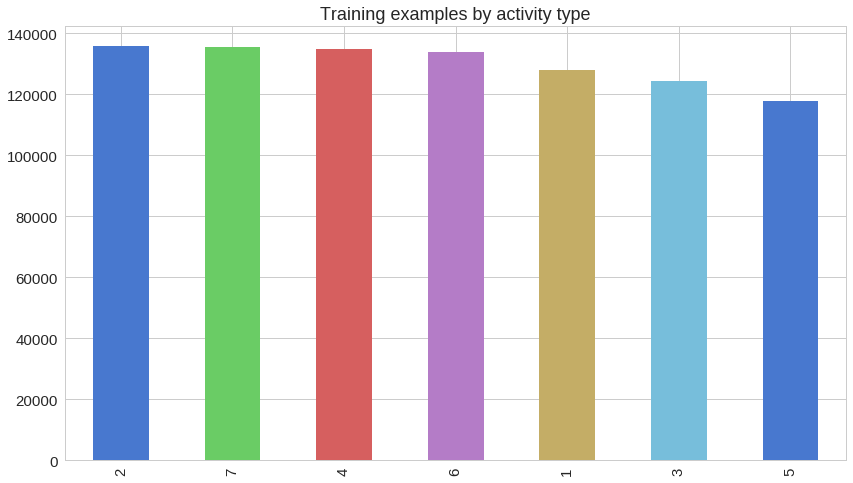

In [0]:
act_id = [0, 1, 2, 3, 4, 5, 6, 7]
act_list = ['DUMMY', 'Bike', 'Car', 'Jogging', 'Metro', 'Tram', 'Train', 'Walking']
df_actList = pd.DataFrame({'activity_id':act_id, 'activity_list':act_list})
df_actList = df_actList.drop(0)

df['activity'].value_counts().plot(kind='bar', title="Training examples by activity type")
list_activities = df['activity']
print(len(list_activities))


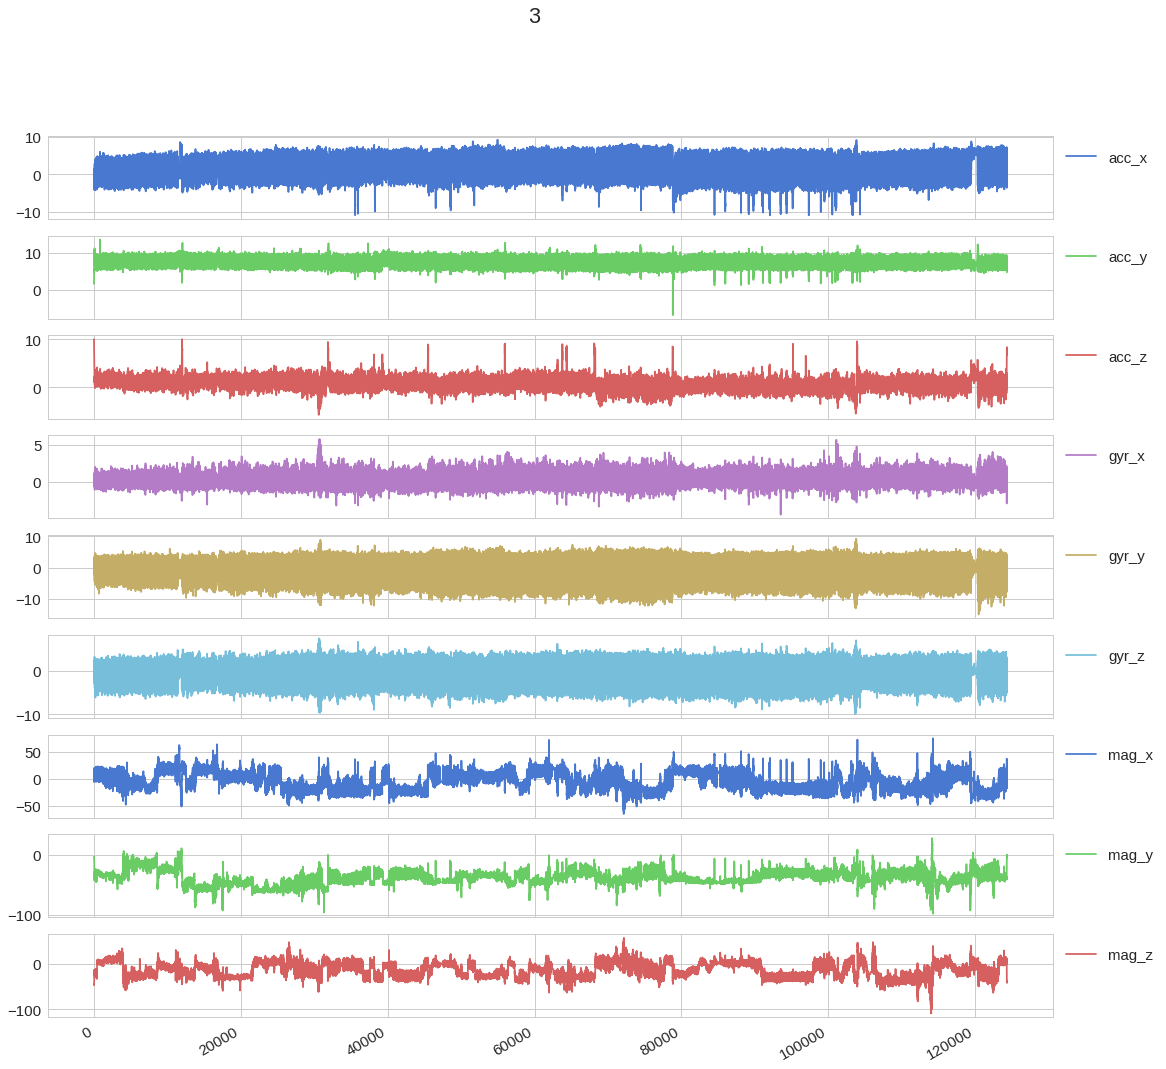

In [0]:
def plot_activity(activity, df):
    act_in_df = df['activity'] == activity
    data = df[act_in_df].reset_index()[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z','mag_x','mag_y','mag_z']]
    axis = data.plot(subplots=True, figsize=(18, 18), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

plot_activity(3, df)


In [0]:
N_TIME_STEPS = 40
N_FEATURES = int(len(df.columns)-2) #### should result in 12 features

step = 20
segments = []
labels = []

for i in range(0, len(df) - N_TIME_STEPS, step):
    acc_xs = df['acc_x'].values[i: i + N_TIME_STEPS]
    acc_ys = df['acc_y'].values[i: i + N_TIME_STEPS]
    acc_zs = df['acc_z'].values[i: i + N_TIME_STEPS]
    acc_ms = df['acc_m'].values[i: i + N_TIME_STEPS]
    
    gyr_xs = df['gyr_x'].values[i: i + N_TIME_STEPS]
    gyr_ys = df['gyr_y'].values[i: i + N_TIME_STEPS]
    gyr_zs = df['gyr_z'].values[i: i + N_TIME_STEPS]
    gyr_ms = df['gyr_m'].values[i: i + N_TIME_STEPS]
    
    mag_xs = df['mag_x'].values[i: i + N_TIME_STEPS]
    mag_ys = df['mag_y'].values[i: i + N_TIME_STEPS]
    mag_zs = df['mag_z'].values[i: i + N_TIME_STEPS]
    mag_ms = df['mag_m'].values[i: i + N_TIME_STEPS]
    
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([acc_xs, acc_ys, acc_zs, acc_ms,
                    gyr_xs, gyr_ys, gyr_zs, gyr_ms,
                    mag_xs, mag_ys, mag_zs, mag_ms
                    ])
    labels.append(label)

In [0]:
np.array(segments).shape

(45503, 12, 40)

In [0]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [0]:
reshaped_segments.shape

(45503, 40, 12)

In [0]:
labels[0]

array([0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments,
                                                    labels,
                                                   test_size=0.2,
                                                   random_state=RANDOM_SEED)

In [0]:

N_CLASSES = int(len(df.activity.unique()))
N_HIDDEN_UNITS = 128

def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES], mean=1.0))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [0]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [0]:
L2_LOSS = 0.0015
l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in
    tf.trainable_variables())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [0]:
LEARNING_RATE = 0.0025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [0]:
N_EPOCHS = 80
BATCH_SIZE = 1024

saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test*100}% | loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print(f'final results: accuracy: {acc_final*100}% | loss: {loss_final}')

epoch: 1 test accuracy: 63.85012865066528% | loss: 3.9655492305755615
epoch: 10 test accuracy: 92.94583201408386% | loss: 2.3405189514160156
epoch: 20 test accuracy: 96.39599919319153% | loss: 1.484668493270874
epoch: 30 test accuracy: 96.95637822151184% | loss: 0.9822812080383301
epoch: 40 test accuracy: 96.95637822151184% | loss: 0.6656854152679443
epoch: 50 test accuracy: 97.4508285522461% | loss: 0.4738143980503082
epoch: 60 test accuracy: 97.6486086845398% | loss: 0.3640257716178894
epoch: 70 test accuracy: 97.30798602104187% | loss: 0.3029930889606476
epoch: 80 test accuracy: 97.4508285522461% | loss: 0.2574450373649597
final results: accuracy: 97.4508285522461% | loss: 0.2574450373649597


In [0]:



pickle.dump(predictions, open("predictions.p", 'wb'))
pickle.dump(history, open("history.p", "wb"))

tf.train.write_graph(sess.graph_def, '.', './har.pbtxt')

saver.save(sess, save_path = "./har.ckpt")
sess.close()


upload_1 = drive.CreateFile({'id': '1PhFgghLth-Igu1d1G6qKSdPU9D4fca73',
                              'title': 'predictions.p',
                               'parents': '15kZwyZbQNqUTG9-0EfiSXflqMUaTJU2V'})
upload_1.SetContentFile('predictions.p')

upload_2 = drive.CreateFile({'id': '1RfExSTb4mQ_pSvubFBxdN6LEgFJ_OFGq',
                              'title': 'history.p',
                               'parents': '15kZwyZbQNqUTG9-0EfiSXflqMUaTJU2V'})
upload_2.SetContentFile('history.p')



upload_1.Upload()
upload_2.Upload()


In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

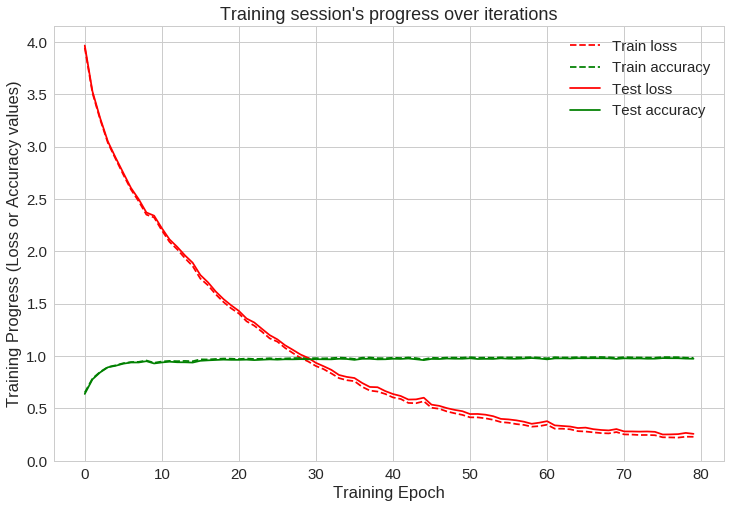

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

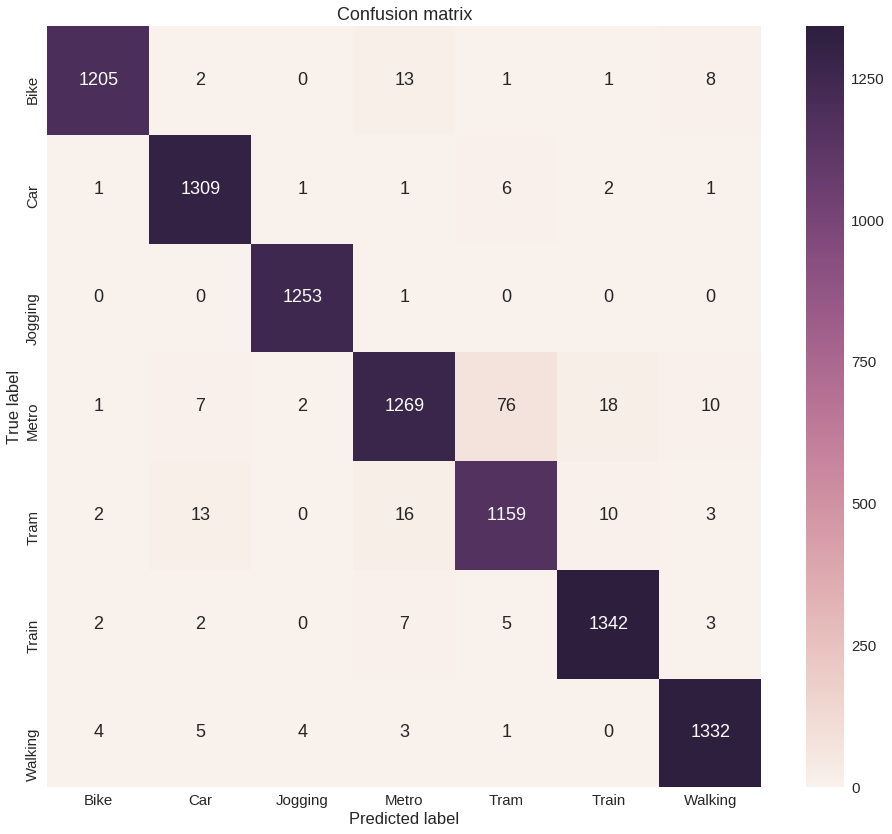

In [0]:
LABELS = ['Fahrrad', 'Auto', 'Laufen', 'U-Bahn', 'Straßenbahn', 'Zug', "Gehen"]

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
#normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Richtige Aktivität')
plt.xlabel('Vorausgesagte Aktivität')
plt.show();